<a href="https://colab.research.google.com/github/trantthanh/EEGthesis/blob/main/testing_sad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Diffusion library

In [ ]:
pip install denoising_diffusion_pytorch

In [ ]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion,Unet1D,GaussianDiffusion1D

input dataset

In [ ]:
import numpy as np
import scipy.io
import pandas as pd
# mne imports
import glob
import os
import re


# EEGNet-specific imports
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/')
from google.colab import drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = '/content/drive/MyDrive/SEED_IV/eeg_raw_data/1'

mat_files = glob.glob(os.path.join(folder_path, '*.mat'))
mat_files.sort(key=lambda f: int(re.search(r'\d+', os.path.basename(f)).group()))
for file in mat_files:
    print(os.path.basename(file))

1_20160518.mat
2_20150915.mat
3_20150919.mat
4_20151111.mat
5_20160406.mat
6_20150507.mat
7_20150715.mat
8_20151103.mat
9_20151028.mat
10_20151014.mat
11_20150916.mat
12_20150725.mat
13_20151115.mat
14_20151205.mat
15_20150508.mat


In [ ]:
segment_length = 512
#segment_length = 300
#segment_length = 1000
step_size = 256

def segment_eeg(eeg_matrix, segment_length, step_size):
    segments = []
    num_channels, total_length = eeg_matrix.shape
    for start in range(0, total_length - segment_length + 1, step_size):
        segment = eeg_matrix[:, start:start + segment_length]
        segments.append(segment)
    return np.stack(segments)

In [7]:
all_segments = []
all_labels = []
label_list = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
#important_channels = [0, 2, 5, 13, 23, 31, 41, 49, 58, 60]
#important_channels = [0,2,3,4,5,13,15,16,17,23,24,25,28,31,35,36,37,41,43,44,46,49,50,52,53,54,57,58,60,61]
for file_path in mat_files:
    mat = scipy.io.loadmat(file_path)
    eeg_keys = [k for k in mat.keys() if k.endswith(tuple(f"_eeg{i}" for i in range(1, 25)))]
    eeg_keys = sorted(eeg_keys, key=lambda x: int(''.join(filter(str.isdigit, x))))

    for i, var_name in enumerate(eeg_keys):
        eeg_matrix = mat[var_name]
    #    eeg_matrix = eeg_matrix[important_channels, :]
        label = label_list[i]

        segments = segment_eeg(eeg_matrix, segment_length, step_size)
        all_segments.extend(segments)
        all_labels.extend([label] * len(segments))

print(f"Total Segments: {len(all_segments)}")
print(f"One Segment Shape: {all_segments[0].shape}")

Total Segments: 39750
One Segment Shape: (62, 512)


In [9]:
np.save("/content/drive/MyDrive/full_segments_512_62ch.npy", all_segments)
np.save("/content/drive/MyDrive/full_labels_512.npy", all_labels)

In [10]:
all_labels = np.array(all_labels)

for i, emotion in enumerate(["Neutral", "Sad", "Happy", "Fear"]):
    count = np.sum(all_labels == i)
    print(f"{emotion}: {count} segments")

Neutral: 10140 segments
Sad: 12090 segments
Happy: 8535 segments
Fear: 8985 segments


Normalize data

In [19]:
all_segments = np.array(all_segments)
all_labels = np.array(all_labels)
emotion_segments = {
    #"Neutral": all_segments[all_labels ==0][:5000],
    "Sad": all_segments[all_labels ==1][:5000],
    #"Fear": all_segments[all_labels ==2][:5000],
    #"Happy": all_segments[all_labels ==3][:5000],
}

In [20]:
from torch.utils.data import Dataset, DataLoader

class EEGEmotionDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def normalize_segment(self, x):
        min_val = x.min()
        max_val = x.max()
        norm_x = 2 * (x - min_val) / (max_val - min_val + 1e-8) - 1
        return norm_x.astype(np.float32)

    def __getitem__(self, idx):
        x = self.segments[idx]
        x = self.normalize_segment(x)
        x = torch.tensor(x, dtype=torch.float32)

        return x


4 diffference EEG segment

In [21]:
emotion_dataloaders = {}
for emotion, segments in emotion_segments.items():
    dataset = EEGEmotionDataset(segments)
    loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
    emotion_dataloaders[emotion] = loader

Create  diffusion model

In [22]:
import torch.optim as optim
models = {}
diffusions = {}
for emotion in ["Neutral","Sad","Fear","Happy" ]:
  model = Unet1D(
      dim=32,
      channels=62,
      dim_mults=(1, 2),
  )

  diffusion = GaussianDiffusion1D(
      model,
      seq_length = 512,
      #seq_length = 300,
      timesteps=200,
  )
  models[emotion] = model
  diffusions[emotion] = diffusion

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = models["Sad"]
diffusion = diffusions["Sad"]
dataloader = emotion_dataloaders["Sad"]

model.to(device)
diffusion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 50
for epoch in range(epochs):
    total_loss=0
    for x in dataloader:
        x = x.to(device)

        optimizer.zero_grad()
        loss = diffusion(x)
        loss.backward()
        optimizer.step()

        total_loss +=loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | SAD Loss: {avg_loss:.4f}")



Epoch 1 | SAD Loss: 1.0072
Epoch 2 | SAD Loss: 0.9426


In [ ]:
save_path = "/content/drive/MyDrive/"
os.makedirs(save_path, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_path, "Sad_diffusion_model_2.pth"))
print(" Saved Sad model!")

 Saved Sad model!


validating with tsne



In [ ]:
model = models["Sad"]
diffusion = diffusions["Sad"]
model.eval()

with torch.no_grad():
    generated_Sad = diffusion.sample(batch_size=500).cpu().numpy()

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
real_Sad = emotion_segments["Sad"][:500]  # shape: (200, 10, 512)

In [ ]:
real_flat = real_Sad.reshape(500, -1)
fake_flat = generated_Sad.reshape(500, -1)

X = np.concatenate([real_flat, fake_flat], axis=0)
y = np.array([0]*500 + [1]*500)  # 0 = real, 1 = generated


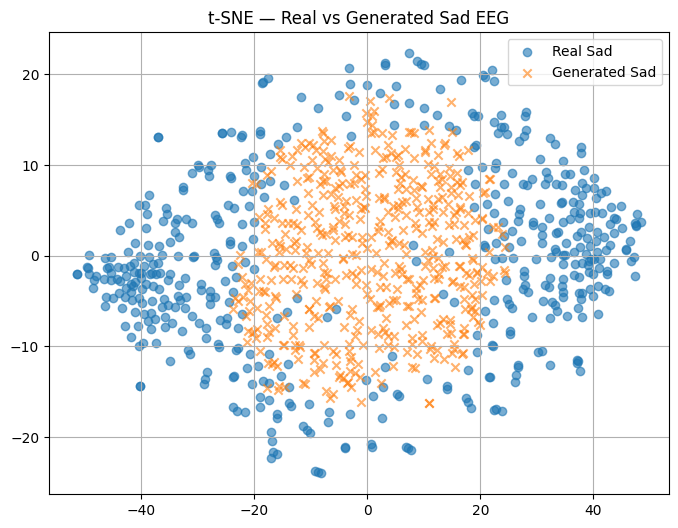

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], label='Real Sad', alpha=0.6)
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], label='Generated Sad', alpha=0.6, marker='x')
plt.title("t-SNE — Real vs Generated Sad EEG")
plt.legend()
plt.grid(True)
plt.show()
